# Preprocessing

### Filter out movies < 5 ratings

In [1]:
import pandas as pd
import glob
%matplotlib inline

In [4]:
df_rating = pd.read_csv('crawl-ratings/rating-filtered.csv')
df_rating

,UserID,MovieID,Rating
0,ur66355076,tt3501632,7
1,ur66355076,tt5776858,8
2,ur66355076,tt2543164,9
3,ur66355076,tt1856101,8
4,ur66355076,tt1825683,9
...,...,...,...
182881,ur3032357,tt0120685,4
182882,ur3032357,tt0145681,7
182883,ur3032357,tt0075148,9
182884,ur3032357,tt0088763,8


In [5]:
movie_stat = df_rating['MovieID'].value_counts()

In [6]:
print(movie_stat.sum())
print(movie_stat[movie_stat>=5].sum())
print(movie_stat[movie_stat<5].sum())

1626980
1464738
162242


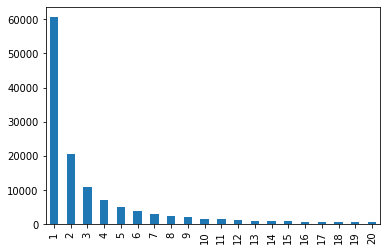

In [9]:
movie_stat.value_counts()[:20].plot.bar()

In [10]:
threshold=5

In [11]:
df_rating_filtered = df_rating[df_rating.MovieID.isin(movie_stat[movie_stat>=threshold].index)]

In [12]:
df_rating_filtered['MovieID'].value_counts()

tt0096697    5929
tt0944947    3676
tt0108778    3239
tt0052520    2891
tt0903747    2409
             ... 
tt0439707       5
tt0079803       5
tt0387887       5
tt7853068       5
tt0037662       5
Name: MovieID, Length: 38718, dtype: int64

In [114]:
df_rating_filtered['UserID'].value_counts()[-15:]

ur103317327    103
ur61423863     102
ur32915980     101
ur49236468     101
ur5411269      100
ur82903451      99
ur22999317      99
ur62942093      99
ur106224983     94
ur40049808      93
ur46768703      91
ur108071848     86
ur94875269      85
ur14330747      61
ur92127176      59
Name: UserID, dtype: int64

In [17]:
df_rating_filtered.to_csv('crawl-ratings/rating-filtered.csv', index=False)

In [108]:
# Other threshold
threshold=30

In [109]:
df_rating_filtered_50 = df_rating[df_rating.MovieID.isin(movie_stat[movie_stat>=threshold].index)]

In [110]:
df_rating_filtered_50['MovieID'].value_counts()

tt0096697    5929
tt0944947    3676
tt0108778    3239
tt0052520    2891
tt0903747    2409
             ... 
tt5316540      30
tt0062861      30
tt2203308      30
tt0037615      30
tt5278426      30
Name: MovieID, Length: 9748, dtype: int64

In [111]:
df_rating_filtered_50['UserID'].value_counts()

ur19009969    15934
ur3032357     15158
ur34575093     9429
ur23172671     9350
ur28967391     9329
              ...  
ur13588546       49
ur11983563       46
ur92127176       40
ur53825238       30
ur14330747       25
Name: UserID, Length: 1105, dtype: int64

## Split train-test

In [2]:
df = pd.read_csv('crawl-ratings/rating-filtered.csv')

In [6]:
user_list = df.UserID.unique()

In [10]:
train_list=[]
test_list=[]
test_rating_per_user=20
for user in user_list:
    user_rating = df[df.UserID == user]
    user_test = user_rating.sample(n=test_rating_per_user,random_state=0)
    test_list.append(user_test)
    train_list.append(user_rating.drop(user_test.index))
    print('.',end='')
train_df = pd.concat(train_list)
test_df = pd.concat(test_list)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [16]:
test_df.UserID.value_counts()

ur35000509    20
ur6918917     20
ur82535306    20
ur50335266    20
ur10115534    20
              ..
ur66601046    20
ur94875269    20
ur0568099     20
ur19998007    20
ur61466300    20
Name: UserID, Length: 1105, dtype: int64

In [17]:
train_df.to_csv('crawl-ratings/train.csv',index=None)

In [19]:
test_df.to_csv('crawl-ratings/test.csv',index=None)

## Translate dataset to user index and movie index

In [55]:
train_df = pd.read_csv('crawl-ratings/train.csv')

In [60]:
user_list = train_df.UserID.unique()

In [78]:
user_df = pd.DataFrame({'UserID':list(user_list),'UserIndex':list(range(user_list.size))})

In [80]:
user_df.to_csv('crawl-users/user-ids.csv',index=None)

In [65]:
user_map = dict(zip(list(user_list),list(range(user_list.size))))

In [68]:
movie_df = pd.read_csv('crawl-movies-info/movie-idx.csv')

In [69]:
movie_map = dict(zip(list(movie_df.MovieID),list(movie_df.MovieIndex)))

In [73]:
train_ids_df = pd.DataFrame({'UserIndex':train_df.UserID.apply(lambda x:user_map[x]),
                            'MovieIndex':train_df.MovieID.apply(lambda x:movie_map[x]),
                            'Rating':train_df.Rating})

In [75]:
train_ids_df.to_csv('crawl-ratings/train_ids.csv',index=None)

In [77]:
test_df = pd.read_csv('crawl-ratings/test.csv')
test_ids_df = pd.DataFrame({'UserIndex':test_df.UserID.apply(lambda x:user_map[x]),
                            'MovieIndex':test_df.MovieID.apply(lambda x:movie_map[x]),
                            'Rating':test_df.Rating})
test_ids_df.to_csv('crawl-ratings/test_ids.csv',index=None)

# Matric Factorization

In [5]:
import os
import itertools
import pickle

import pandas as pd
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import Reader

In [2]:
# Load the data set from file
file_path = os.path.join("crawl-ratings", "train.csv")
reader = Reader(line_format="user item rating",
                sep=",",
                rating_scale=(1, 10),
                skip_lines=1)
data = Dataset.load_from_file(file_path, reader=reader)

# sample random trainset and validation set
# val set is made of 25% of the ratings.
train_set, validation_set = train_test_split(data, test_size=0.25, random_state=0)

In [4]:
# Validation process
n_factors_list = [10, 50, 100, 150,
                  200]  # The number of factors, default value is 100
reg_all_list = [
    0.01,
    0.02,
    0.05,
    0.1,
]  # The regularization term for all params, default value is 0.02

n_factors_best = reg_all_best = model_best = None
rmse_best = float("inf")
rmse_list = []

for n_factors, reg_all in itertools.product(n_factors_list, reg_all_list):
    algo = SVD(n_factors=n_factors, reg_all=reg_all)
    algo.fit(train_set)
    predictions = algo.test(validation_set)

    rmse = accuracy.rmse(predictions)
    rmse_list.append(rmse)
    print(f"Rmse for {n_factors} factors with {reg_all} regesion is {rmse}")
    if rmse < rmse_best:
        n_factors_best, reg_all_best, model_best, rmse_best = n_factors, reg_all, algo, rmse

RMSE: 1.5662
Rmse for 10 factors with 0.01 regesion is 1.5662058102415837
RMSE: 1.5467
Rmse for 10 factors with 0.02 regesion is 1.5466890582769512
RMSE: 1.5294
Rmse for 10 factors with 0.05 regesion is 1.5294474670003726
RMSE: 1.5326
Rmse for 10 factors with 0.1 regesion is 1.5326316573629475
RMSE: 1.6145
Rmse for 50 factors with 0.01 regesion is 1.614496881519193
RMSE: 1.5767
Rmse for 50 factors with 0.02 regesion is 1.5767087967250086
RMSE: 1.5265
Rmse for 50 factors with 0.05 regesion is 1.526468134266003
RMSE: 1.5249
Rmse for 50 factors with 0.1 regesion is 1.5248749218540365
RMSE: 1.6172
Rmse for 100 factors with 0.01 regesion is 1.617223977555844
RMSE: 1.5768
Rmse for 100 factors with 0.02 regesion is 1.5768020006742227
RMSE: 1.5239
Rmse for 100 factors with 0.05 regesion is 1.5239266282412918
RMSE: 1.5205
Rmse for 100 factors with 0.1 regesion is 1.5205153418325743
RMSE: 1.6128
Rmse for 150 factors with 0.01 regesion is 1.612800238584212
RMSE: 1.5703
Rmse for 150 factors with 0

In [5]:
# save model
file_name = "matrix_decomposition_model.pkl"
with open(file_name, "wb") as f:
    pickle.dump(model_best, f)

In [6]:
# load model
loaded_model = None

with open(file_name, "rb") as f:
    loaded_model = pickle.load(f)

In [7]:
accuracy.rmse(loaded_model.test(validation_set))

RMSE: 1.5199


1.5198517442645045

In [2]:
user_rating = Dataset.load_from_file(os.path.join("new_user", "rating_all.csv"), reader)
all_train_set = user_rating.build_full_trainset()


In [41]:
algo.fit(all_train_set)

In [44]:
algo.predict("ur26266323","tt0310281")

Prediction(uid='ur26266323', iid='tt0310281', r_ui=None, est=7.126198497368478, details={'was_impossible': False})

In [49]:
all_movies_df = pd.read_csv(os.path.join("crawl-movies-info", "movie-idx.csv"))

In [50]:
pred = [algo.predict("u0", movieId) for movieId in all_movies_df["MovieID"]]

In [65]:
pred.sort(key=lambda x:x.est, reverse=True)

In [66]:
pred[:100]

[Prediction(uid='u0', iid='tt2103188', r_ui=None, est=8.794842040254897, details={'was_impossible': False}),
 Prediction(uid='u0', iid='tt5275892', r_ui=None, est=8.558307170897388, details={'was_impossible': False}),
 Prediction(uid='u0', iid='tt0397042', r_ui=None, est=8.545421519855788, details={'was_impossible': False}),
 Prediction(uid='u0', iid='tt0071075', r_ui=None, est=8.51977031660955, details={'was_impossible': False}),
 Prediction(uid='u0', iid='tt1877514', r_ui=None, est=8.518343533446552, details={'was_impossible': False}),
 Prediction(uid='u0', iid='tt1568322', r_ui=None, est=8.510734349419534, details={'was_impossible': False}),
 Prediction(uid='u0', iid='tt1479962', r_ui=None, est=8.50275728962319, details={'was_impossible': False}),
 Prediction(uid='u0', iid='tt5491994', r_ui=None, est=8.493235941207915, details={'was_impossible': False}),
 Prediction(uid='u0', iid='tt0081846', r_ui=None, est=8.485882723513075, details={'was_impossible': False}),
 Prediction(uid='u0',

In [38]:
def mfcf_predict(movie_ids, scores):
    test_df = pd.read_csv(os.path.join("crawl-ratings","train_ids.csv"))
    user_df = pd.DataFrame(list(zip([2000]*len(movie_ids), movie_ids, scores)), columns=["UserIndex", "MovieIndex", "Rating"])
    df = pd.concat([test_df, user_df])
    reader = Reader(line_format="user item rating",
                rating_scale=(1, 10))
    data = Dataset.load_from_df(df[["UserIndex", "MovieIndex", "Rating"]], reader)
    all_movie_df = pd.read_csv(os.path.join("crawl-movies-info", "movie-idx.csv"))
    all_train_set = data.build_full_trainset()
    algo = SVD(n_factors=100, reg_all=0.1)
    algo.fit(all_train_set)
    pred = [algo.predict(2000, movieIdx) for movieIdx in all_movie_df["MovieIndex"]]
    return pred

# Neighbor based CF

In [4]:
import pandas as pd 
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse 

In [2]:
class NBCF(object):
    def __init__(self, data,user_col,item_col,rating_col, k_nearest_neighbor = 5, dist_func=cosine_similarity):
        self.data = data
        self.user_col = user_col
        self.item_col = item_col
        self.rating_col = rating_col
        
        self.users = self.data[user_col].unique()
        self.items = self.data[item_col].unique()
        self.user_to_idx = dict(zip(list(self.users),list(range(self.users.size))))
        self.item_to_idx = dict(zip(list(self.items),list(range(self.items.size))))
        
        self.k_nearest_neighbor = k_nearest_neighbor
        self.dist_func = dist_func
        
    def normalize(self):
        self.data_norm = self.data.copy()
        self.mu = {}
        for user in self.users:
            user_mean = self.data[self.data[self.user_col] == user][self.rating_col].mean()
            self.mu[user] = user_mean
            self.data_norm.loc[self.data[self.user_col] == user, self.rating_col] -= user_mean
        
        self.matrix = sparse.coo_matrix((self.data_norm[self.rating_col],
            (self.data_norm[self.item_col].apply(lambda x: self.item_to_idx[x]), 
             self.data_norm[self.user_col].apply(lambda x: self.user_to_idx[x]))), 
            (self.items.size, self.users.size))
        
        self.matrix = self.matrix.tocsr()
        
    def similarity(self):
        self.S = self.dist_func(self.matrix.T, self.matrix.T)     
        
    def fit(self):
        self.normalize()
        self.similarity()

    def predict_rating(self, userID, itemID):
#         print(userID,itemID)
        rating_for_item = self.data[self.data[self.item_col] == itemID]
#         print(rating_for_item)
        user_rated_item_idx = np.fromiter(map(self.user_to_idx.__getitem__, rating_for_item[self.user_col]),dtype=np.int)
        similarity_with_user = self.S[self.user_to_idx[userID],user_rated_item_idx]
        nearest_users_idx = np.argsort(similarity_with_user)[-self.k_nearest_neighbor:] 
        nearest_distances = similarity_with_user[nearest_users_idx]
        nearest_rating = self.matrix[1, user_rated_item_idx[nearest_users_idx]]

        return (nearest_rating*nearest_distances)[0]/(np.abs(nearest_distances).sum() + 1e-8) + self.mu[userID]

In [3]:
# test movielens
train_data = pd.read_csv('ml-100k/ub.base',sep='\t',header=None)

rs = NBCF(train_data,user_col=0,item_col=1,rating_col=2,k_nearest_neighbor=30)
rs.fit()

rate_test = pd.read_csv('ml-100k/ub.test',sep='\t',header=None)
n_tests = rate_test.shape[0]
SE = 0 # squared error
for n in range(n_tests):
#     print(rate_test.iloc[n, 0], rate_test.iloc[n, 1])
    pred = rs.predict_rating(rate_test.iloc[n, 0], rate_test.iloc[n, 1])
#     print(pred,rate_test.iloc[n, 2])
    SE += (pred - rate_test.iloc[n, 2])**2 

RMSE = np.sqrt(SE/n_tests)
print('RMSE =', RMSE)

RMSE = 1.0691429261084866


In [3]:
# test our data
data = pd.read_csv('crawl-ratings/train.csv')

rs = NBCF(data,user_col='UserID',item_col='MovieID',rating_col='Rating',k_nearest_neighbor=5)
rs.fit()
test_data=pd.read_csv('crawl-ratings/test.csv')
SE = 0
for i, row in test_data.iterrows():
    if i>=1000:
        break
    pred = rs.predict_rating(row['UserID'],row['MovieID'])
    SE += (pred - row['Rating'])**2 

RMSE = np.sqrt(SE/1000)
print('k = ',rs.k_nearest_neighbor)
print('RMSE =', RMSE)

k =  5
RMSE = 2.621727320191911


In [4]:
# test our data
data = pd.read_csv('crawl-ratings/train.csv')

rs = NBCF(data,user_col='UserID',item_col='MovieID',rating_col='Rating',k_nearest_neighbor=15)
rs.fit()
test_data=pd.read_csv('crawl-ratings/test.csv')
SE = 0
for i, row in test_data.iterrows():
    if i>=1000:
        break
    pred = rs.predict_rating(row['UserID'],row['MovieID'])
    SE += (pred - row['Rating'])**2 

RMSE = np.sqrt(SE/1000)
print('k = ',rs.k_nearest_neighbor)
print('RMSE =', RMSE)

k =  15
RMSE = 2.5220999284369174


In [5]:
# test our data
data = pd.read_csv('crawl-ratings/train.csv')

rs = NBCF(data,user_col='UserID',item_col='MovieID',rating_col='Rating',k_nearest_neighbor=30)
rs.fit()
test_data=pd.read_csv('crawl-ratings/test.csv')
SE = 0
for i, row in test_data.iterrows():
    if i>=1000:
        break
    pred = rs.predict_rating(row['UserID'],row['MovieID'])
    SE += (pred - row['Rating'])**2 

RMSE = np.sqrt(SE/1000)
print('k = ',rs.k_nearest_neighbor)
print('RMSE =', RMSE)

k =  30
RMSE = 2.4755570216519267


In [5]:
# test our data
data = pd.read_csv('crawl-ratings/train.csv')

rs = NBCF(data,user_col='UserID',item_col='MovieID',rating_col='Rating',k_nearest_neighbor=30)
rs.fit()

In [6]:
test_data=pd.read_csv('crawl-ratings/test.csv')
output_file = open('crawl-ratings/predict.csv','w')
output_file.write('UserID,MovieID,Rating\n')
SE = 0
for i, row in test_data.iterrows():
    pred = rs.predict_rating(row['UserID'],row['MovieID'])
    output_file.write('{},{},{}\n'.format(row['UserID'],row['MovieID'],pred))
    SE += (pred - row['Rating'])**2 

RMSE = np.sqrt(SE/test_data.shape[0])
print('RMSE =', RMSE)
output_file.close()

RMSE = 2.697235202403294


# Content based RS

In [31]:
import pandas as pd
df = pd.read_csv('crawl-movies-info/movies-info.csv')

In [32]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=True, norm ='l2')
tfidf = transformer.fit_transform(df.values[:,1:].tolist()).toarray()

In [33]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn import linear_model
 
def content_based_predict_rating(movie_ids, scores,alpha=0.01):
    clf = Ridge(alpha=alpha, fit_intercept  = True)
    Xhat = tfidf[movie_ids, :]
    
    clf.fit(Xhat, scores)
    W = clf.coef_
    b = clf.intercept_
    rating = tfidf.dot(W) + b
    return rating

In [21]:
# test
movie_ids=np.array([1,2,3,4,5,6])
scores=np.array([1.0,3.0,5.0,6.0,2.0,8.0])
predict_rating(movie_ids,scores)

array([3.67794815, 1.08623024, 2.98916455, ..., 4.63962796, 4.63962796,
       4.63962796])

In [37]:
# calculate all predicting in training set
train_df = pd.read_csv('crawl-ratings/train_ids.csv')
test_df = pd.read_csv('crawl-ratings/train_ids.csv')
SE=0

for user in train_df.UserIndex.unique():
    train_rating = train_df[train_df.UserIndex==user]
    predict = predict_rating(train_rating.MovieIndex.values,train_rating.Rating.values)
    
    test_rating = test_df[test_df.UserIndex==user]
    SE += np.sum((test_rating.Rating - predict[test_rating.MovieIndex.values])**2)

In [39]:
RMSE = np.sqrt(SE/test_df.shape[0])
RMSE

1.7851635088044007

# Final Model

In [2]:
import numpy as np

In [39]:
def final_model_predict(movie_ids, scores):
    content_based_predict = content_based_predict_rating(movie_ids,scores)
    mfcf_pred = mfcf_predict(movie_ids, scores)
    print(mfcf_pred)
    return (content_based_predict+np.array([pred.est for pred in mfcf_pred]))/2
movie_ids=np.array([1,2,3,4,5,6,10])
scores=np.array([1.0,3.0,5.0,6.0,2.0,8.0])

In [61]:
ratings = final_model_predict(movie_ids, scores)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [62]:
ratings.argsort()[:10][::-1]

array([ 9127, 21343, 36555, 38609, 12871,  1751, 19185, 37675, 35268,
       13603], dtype=int64)